<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_COMBINED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins"
DATA_SONG_DIR = "Chunked"
DATA_IMG_DIR = "Chunked"

files = []
western_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      western_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
western_files = random.sample(western_files, 2008)

indian_files = []
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, "Indian_numpy")):
  for file in fileList:
    if(True):
      indian_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

files = indian_files + western_files
dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

,Images,songs,labels
0,indianNizhalinaiNijamum_mel_0.npy,indianNizhalinaiNijamum_mel_0.npy,Indian_numpy
1,indianNizhalinaiNijamum_mel_1.npy,indianNizhalinaiNijamum_mel_1.npy,Indian_numpy
2,indianOhOh_mel_0.npy,indianOhOh_mel_0.npy,Indian_numpy
3,indianOhOh_mel_1.npy,indianOhOh_mel_1.npy,Indian_numpy
4,indianOnnavittaYaarumYenakilla_mel_0.npy,indianOnnavittaYaarumYenakilla_mel_0.npy,Indian_numpy


In [5]:
if class_level_loss_mode == "all":
  indian_dataDF = pd.DataFrame(indian_files, columns=['Images','songs','labels'])
  indian_dataDF.head()
elif class_level_loss_mode == "test":
  indian_dataDF = dataDF[dataDF['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [6]:
if class_level_loss_mode == "all":
  western_dataDF = pd.DataFrame(western_files, columns=['Images','songs','labels'])
  western_dataDF.head()
elif class_level_loss_mode == "test":
  western_dataDF = dataDF[dataDF['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)

In [7]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,4016,4016
Western_numpy,2008,2008


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Chunked/Indian_numpy/indianGoriyanGallan_mel_0.npy
74.715294


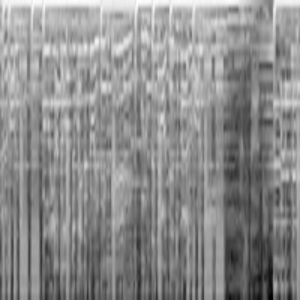

In [8]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



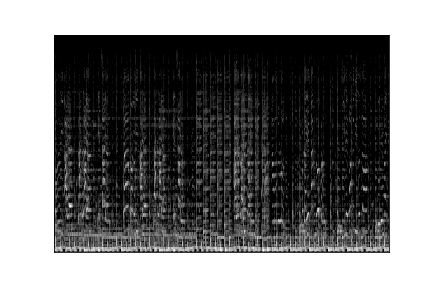

In [9]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [10]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,indianNizhalinaiNijamum_mel_0.npy,indianNizhalinaiNijamum_mel_0.npy,Indian_numpy,0
1,indianNizhalinaiNijamum_mel_1.npy,indianNizhalinaiNijamum_mel_1.npy,Indian_numpy,0
2,indianOhOh_mel_0.npy,indianOhOh_mel_0.npy,Indian_numpy,0
3,indianOhOh_mel_1.npy,indianOhOh_mel_1.npy,Indian_numpy,0
4,indianOnnavittaYaarumYenakilla_mel_0.npy,indianOnnavittaYaarumYenakilla_mel_0.npy,Indian_numpy,0


In [11]:
indian_dataDF['encoded_labels'] = lb.transform(indian_dataDF['labels'])
western_dataDF['encoded_labels'] = lb.transform(western_dataDF['labels'])

In [12]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,4016,4016
Western_numpy,1,2008,2008


In [13]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=9)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


if class_level_loss_mode == "test":
  western_dataDF = df_test[df_test['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)
  indian_dataDF = df_test[df_test['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [14]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,1405,1405


In [15]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,603,603


In [16]:
indian_dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205


In [17]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [18]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [19]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [20]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [21]:
indian_dataset = MEL_Dataset(indian_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
western_dataset = MEL_Dataset(western_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

indian_loader = torch.utils.data.DataLoader(indian_dataset, batch_size=batch_size)
western_loader = torch.utils.data.DataLoader(western_dataset, batch_size=batch_size)


In [22]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

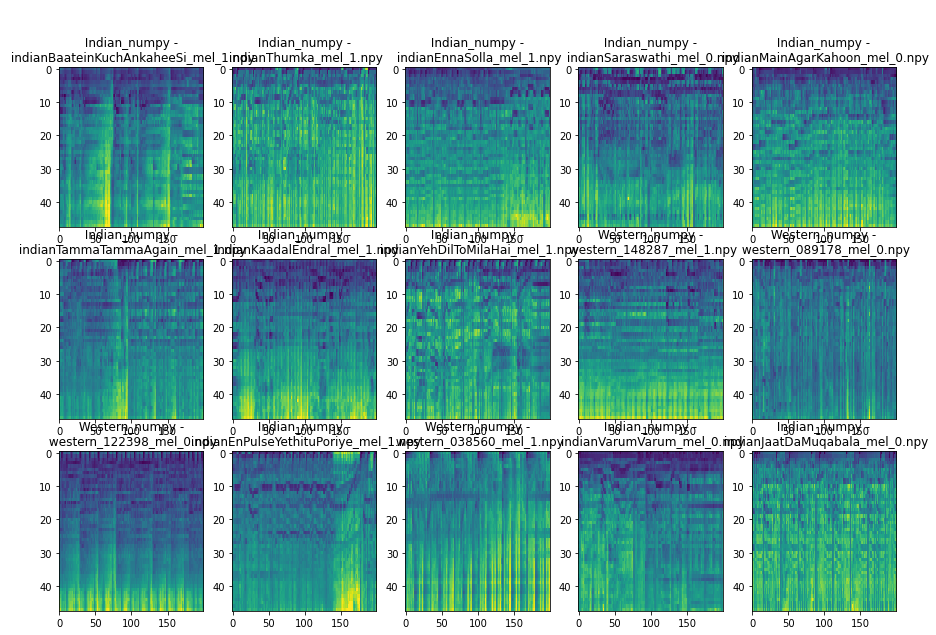

In [23]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

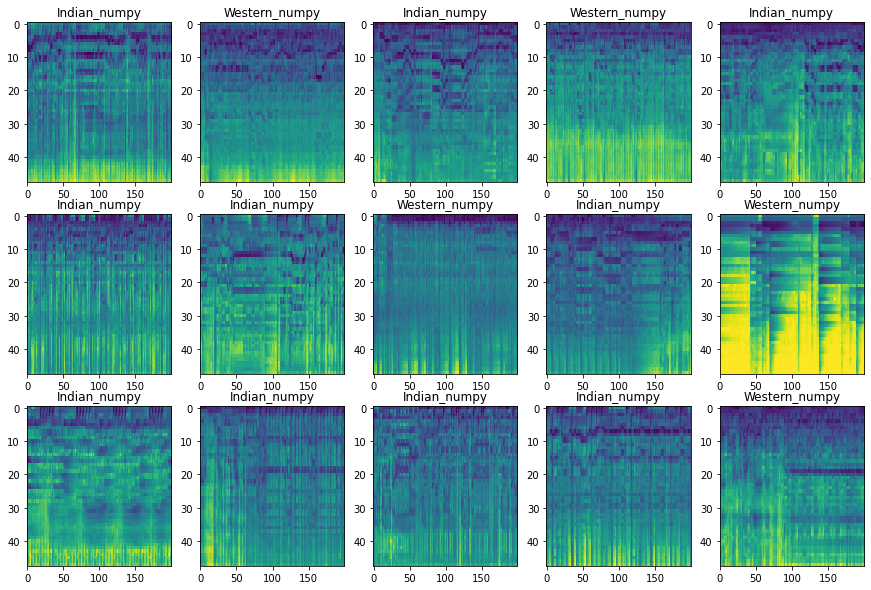

In [24]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

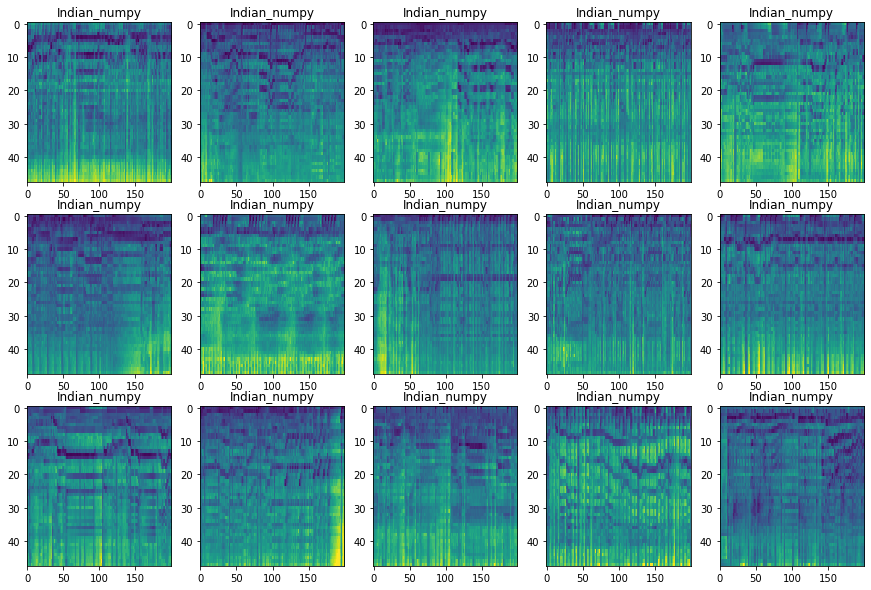

In [25]:
# get some random training images
dataiter = iter(indian_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

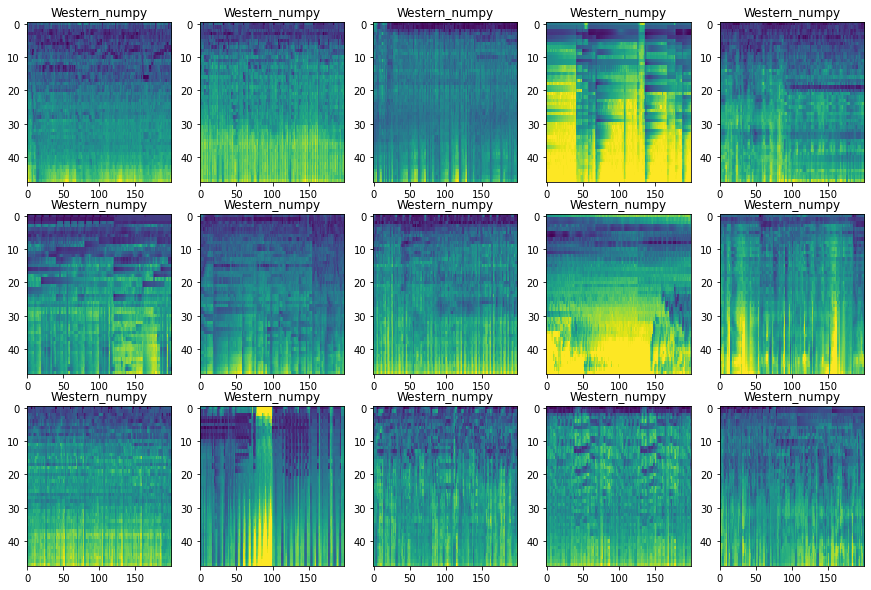

In [26]:
# get some random training images
dataiter = iter(western_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [27]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [28]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1375.779
[1,     2] loss: 1208.156
[1,     3] loss: 1174.661
[1,     4] loss: 1207.101
[1,     5] loss: 948.030
[1,     6] loss: 797.980
[1,     7] loss: 669.892
[1,     8] loss: 385.526
[1,     9] loss: 168.377
[1,    10] loss: 625.362
[1,    11] loss: 298.366
[1,    12] loss: 146.216
[1,    13] loss: 110.565
[1,    14] loss: 123.002
[1,    15] loss: 163.687
[1,    16] loss: 229.299
[1,    17] loss: 222.603
[1,    18] loss: 213.951
[1,    19] loss: 206.374
[1,    20] loss: 136.095
[1,    21] loss: 150.215
[1,    22] loss: 107.504
[1,    23] loss: 121.003
[1,    24] loss: 106.477
[1,    25] loss: 143.430
[1,    26] loss: 156.537
[1,    27] loss: 140.612
[1,    28] loss: 126.332
[1,    29] loss: 124.021
[1,    30] loss: 127.160
[1,    31] loss: 88.837
[1,    32] loss: 95.129
[1,    33] loss: 97.907
[1,    34] loss: 104.960
[1,    35] loss: 172.286
[1,    36] loss: 94.672
[1,    37] loss: 108.079
[1,    38] loss: 105.363
[1,    39] loss: 101.470
[1,    40] loss: 102.224


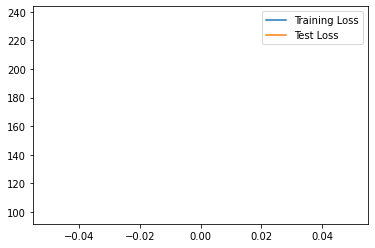

LOSS of the network on the test images: 1454 %
Mean of the network on the Indian images after epoch 0 is 80.80952580769856
LOSS of the network on the test images: 1316 %
Mean of the network on the Western images after epoch 0 is 146.25248209635416


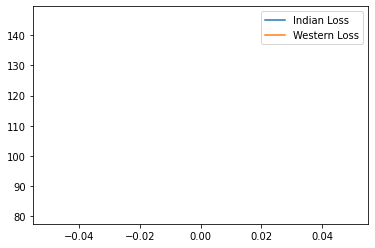

[2,     1] loss: 94.708
[2,     2] loss: 88.678
[2,     3] loss: 79.579
[2,     4] loss: 122.145
[2,     5] loss: 90.483
[2,     6] loss: 88.556
[2,     7] loss: 106.218
[2,     8] loss: 111.721
[2,     9] loss: 99.985
[2,    10] loss: 93.611
[2,    11] loss: 90.699
[2,    12] loss: 108.123
[2,    13] loss: 87.848
[2,    14] loss: 76.412
[2,    15] loss: 79.647
[2,    16] loss: 107.165
[2,    17] loss: 91.472
[2,    18] loss: 91.908
[2,    19] loss: 92.248
[2,    20] loss: 82.749
[2,    21] loss: 89.207
[2,    22] loss: 80.889
[2,    23] loss: 90.417
[2,    24] loss: 75.955
[2,    25] loss: 100.568
[2,    26] loss: 88.710
[2,    27] loss: 95.166
[2,    28] loss: 89.228
[2,    29] loss: 88.118
[2,    30] loss: 98.819
[2,    31] loss: 74.864
[2,    32] loss: 75.139
[2,    33] loss: 78.417
[2,    34] loss: 82.964
[2,    35] loss: 121.331
[2,    36] loss: 75.365
[2,    37] loss: 78.441
[2,    38] loss: 73.064
[2,    39] loss: 78.746
[2,    40] loss: 86.403
[2,    41] loss: 73.665
[2,    42

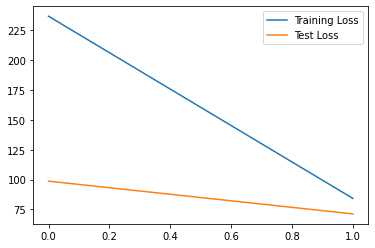

LOSS of the network on the test images: 1204 %
Mean of the network on the Indian images after epoch 1 is 66.94106271531847
LOSS of the network on the test images: 787 %
Mean of the network on the Western images after epoch 1 is 87.4757342868381


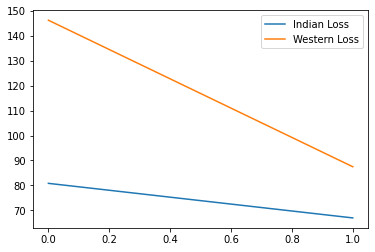

[3,     1] loss: 68.119
[3,     2] loss: 66.548
[3,     3] loss: 61.366
[3,     4] loss: 74.672
[3,     5] loss: 67.348
[3,     6] loss: 66.724
[3,     7] loss: 73.164
[3,     8] loss: 71.968
[3,     9] loss: 61.488
[3,    10] loss: 72.605
[3,    11] loss: 66.931
[3,    12] loss: 66.410
[3,    13] loss: 68.697
[3,    14] loss: 57.603
[3,    15] loss: 67.523
[3,    16] loss: 67.613
[3,    17] loss: 62.432
[3,    18] loss: 64.520
[3,    19] loss: 68.200
[3,    20] loss: 66.204
[3,    21] loss: 71.319
[3,    22] loss: 62.410
[3,    23] loss: 67.790
[3,    24] loss: 59.887
[3,    25] loss: 69.987
[3,    26] loss: 68.458
[3,    27] loss: 71.400
[3,    28] loss: 70.980
[3,    29] loss: 66.181
[3,    30] loss: 69.977
[3,    31] loss: 61.962
[3,    32] loss: 60.466
[3,    33] loss: 60.537
[3,    34] loss: 65.317
[3,    35] loss: 85.603
[3,    36] loss: 62.938
[3,    37] loss: 61.262
[3,    38] loss: 63.198
[3,    39] loss: 68.425
[3,    40] loss: 76.482
[3,    41] loss: 63.553
[3,    42] loss:

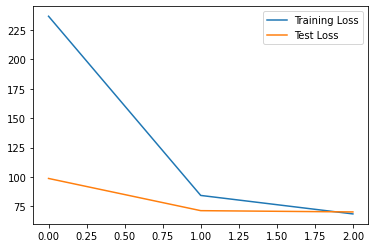

LOSS of the network on the test images: 1190 %
Mean of the network on the Indian images after epoch 2 is 66.14834382798936
LOSS of the network on the test images: 770 %
Mean of the network on the Western images after epoch 2 is 85.65733591715495


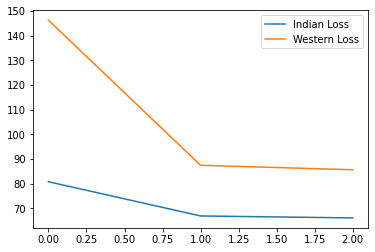

[4,     1] loss: 66.999
[4,     2] loss: 65.950
[4,     3] loss: 60.560
[4,     4] loss: 73.536
[4,     5] loss: 66.616
[4,     6] loss: 66.186
[4,     7] loss: 72.368
[4,     8] loss: 71.091
[4,     9] loss: 60.795
[4,    10] loss: 71.839
[4,    11] loss: 66.368
[4,    12] loss: 65.608
[4,    13] loss: 68.150
[4,    14] loss: 57.602
[4,    15] loss: 67.104
[4,    16] loss: 65.603
[4,    17] loss: 61.856
[4,    18] loss: 64.249
[4,    19] loss: 67.871
[4,    20] loss: 65.943
[4,    21] loss: 70.805
[4,    22] loss: 62.126
[4,    23] loss: 67.184
[4,    24] loss: 59.483
[4,    25] loss: 69.268
[4,    26] loss: 67.867
[4,    27] loss: 70.928
[4,    28] loss: 70.548
[4,    29] loss: 65.651
[4,    30] loss: 68.560
[4,    31] loss: 61.675
[4,    32] loss: 60.102
[4,    33] loss: 60.033
[4,    34] loss: 64.873
[4,    35] loss: 84.183
[4,    36] loss: 62.356
[4,    37] loss: 60.636
[4,    38] loss: 62.887
[4,    39] loss: 67.856
[4,    40] loss: 75.859
[4,    41] loss: 62.985
[4,    42] loss:

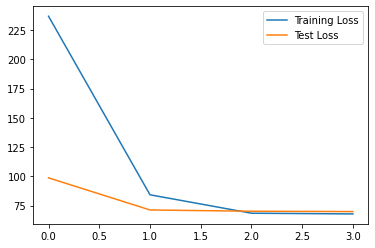

LOSS of the network on the test images: 1188 %
Mean of the network on the Indian images after epoch 3 is 66.00190925598145
LOSS of the network on the test images: 765 %
Mean of the network on the Western images after epoch 3 is 85.01112704806857


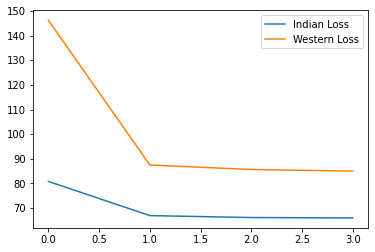

[5,     1] loss: 66.494
[5,     2] loss: 65.254
[5,     3] loss: 60.444
[5,     4] loss: 72.762
[5,     5] loss: 66.267
[5,     6] loss: 65.852
[5,     7] loss: 71.695
[5,     8] loss: 70.422
[5,     9] loss: 60.291
[5,    10] loss: 71.516
[5,    11] loss: 66.066
[5,    12] loss: 64.844
[5,    13] loss: 67.849
[5,    14] loss: 57.218
[5,    15] loss: 66.766
[5,    16] loss: 64.845
[5,    17] loss: 61.536
[5,    18] loss: 63.848
[5,    19] loss: 67.528
[5,    20] loss: 65.577
[5,    21] loss: 70.396
[5,    22] loss: 61.671
[5,    23] loss: 66.845
[5,    24] loss: 59.100
[5,    25] loss: 68.671
[5,    26] loss: 67.250
[5,    27] loss: 70.438
[5,    28] loss: 70.273
[5,    29] loss: 65.104
[5,    30] loss: 67.880
[5,    31] loss: 61.206
[5,    32] loss: 59.791
[5,    33] loss: 59.542
[5,    34] loss: 64.362
[5,    35] loss: 83.709
[5,    36] loss: 61.988
[5,    37] loss: 60.130
[5,    38] loss: 62.900
[5,    39] loss: 67.249
[5,    40] loss: 75.311
[5,    41] loss: 62.778
[5,    42] loss:

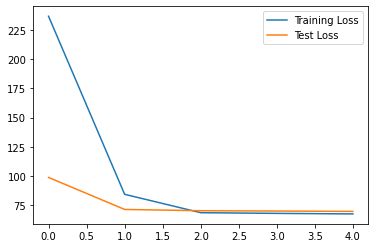

LOSS of the network on the test images: 1185 %
Mean of the network on the Indian images after epoch 4 is 65.86244646708171
LOSS of the network on the test images: 759 %
Mean of the network on the Western images after epoch 4 is 84.35582817925348


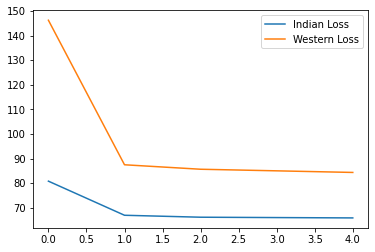

[6,     1] loss: 65.969
[6,     2] loss: 64.769
[6,     3] loss: 60.308
[6,     4] loss: 72.320
[6,     5] loss: 65.706
[6,     6] loss: 65.735
[6,     7] loss: 70.965
[6,     8] loss: 69.712
[6,     9] loss: 59.932
[6,    10] loss: 70.889
[6,    11] loss: 65.782
[6,    12] loss: 64.126
[6,    13] loss: 67.430
[6,    14] loss: 57.250
[6,    15] loss: 66.313
[6,    16] loss: 64.760
[6,    17] loss: 61.093
[6,    18] loss: 63.577
[6,    19] loss: 67.204
[6,    20] loss: 65.248
[6,    21] loss: 70.070
[6,    22] loss: 61.202
[6,    23] loss: 66.725
[6,    24] loss: 58.675
[6,    25] loss: 67.992
[6,    26] loss: 66.510
[6,    27] loss: 69.879
[6,    28] loss: 69.897
[6,    29] loss: 64.576
[6,    30] loss: 67.288
[6,    31] loss: 60.731
[6,    32] loss: 59.387
[6,    33] loss: 59.005
[6,    34] loss: 63.844
[6,    35] loss: 83.103
[6,    36] loss: 61.480
[6,    37] loss: 59.573
[6,    38] loss: 62.615
[6,    39] loss: 66.630
[6,    40] loss: 74.469
[6,    41] loss: 62.475
[6,    42] loss:

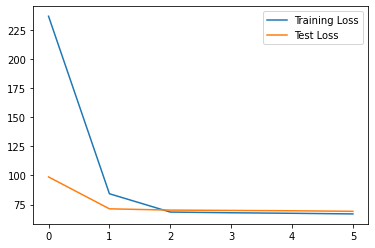

LOSS of the network on the test images: 1180 %
Mean of the network on the Indian images after epoch 5 is 65.58038817511664
LOSS of the network on the test images: 751 %
Mean of the network on the Western images after epoch 5 is 83.48316531711154


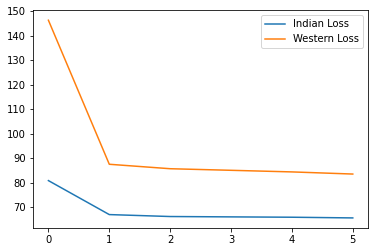

[7,     1] loss: 65.161
[7,     2] loss: 64.196
[7,     3] loss: 59.764
[7,     4] loss: 71.961
[7,     5] loss: 64.702
[7,     6] loss: 65.304
[7,     7] loss: 70.168
[7,     8] loss: 68.550
[7,     9] loss: 59.483
[7,    10] loss: 69.896
[7,    11] loss: 65.050
[7,    12] loss: 63.522
[7,    13] loss: 66.585
[7,    14] loss: 56.998
[7,    15] loss: 65.447
[7,    16] loss: 64.155
[7,    17] loss: 60.346
[7,    18] loss: 62.894
[7,    19] loss: 66.661
[7,    20] loss: 64.679
[7,    21] loss: 69.161
[7,    22] loss: 60.523
[7,    23] loss: 65.918
[7,    24] loss: 58.035
[7,    25] loss: 67.217
[7,    26] loss: 65.383
[7,    27] loss: 69.044
[7,    28] loss: 68.839
[7,    29] loss: 63.628
[7,    30] loss: 66.124
[7,    31] loss: 59.912
[7,    32] loss: 58.773
[7,    33] loss: 57.952
[7,    34] loss: 62.876
[7,    35] loss: 82.006
[7,    36] loss: 60.119
[7,    37] loss: 58.704
[7,    38] loss: 61.518
[7,    39] loss: 65.293
[7,    40] loss: 72.537
[7,    41] loss: 61.585
[7,    42] loss:

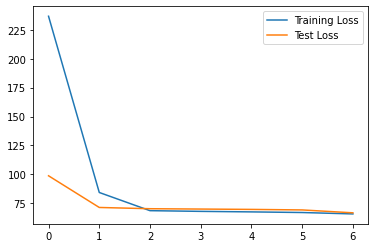

LOSS of the network on the test images: 1141 %
Mean of the network on the Indian images after epoch 6 is 63.393112394544815
LOSS of the network on the test images: 720 %
Mean of the network on the Western images after epoch 6 is 80.10359319051106


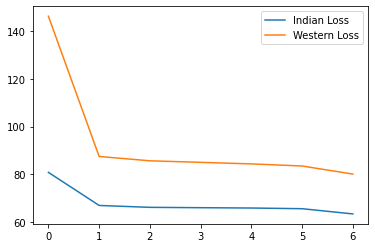

[8,     1] loss: 62.468
[8,     2] loss: 62.482
[8,     3] loss: 57.460
[8,     4] loss: 69.423
[8,     5] loss: 62.963
[8,     6] loss: 62.505
[8,     7] loss: 67.430
[8,     8] loss: 66.300
[8,     9] loss: 56.442
[8,    10] loss: 66.813
[8,    11] loss: 62.999
[8,    12] loss: 61.779
[8,    13] loss: 63.943
[8,    14] loss: 54.556
[8,    15] loss: 62.853
[8,    16] loss: 61.513
[8,    17] loss: 57.884
[8,    18] loss: 61.077
[8,    19] loss: 64.315
[8,    20] loss: 62.162
[8,    21] loss: 65.651
[8,    22] loss: 58.525
[8,    23] loss: 63.238
[8,    24] loss: 56.212
[8,    25] loss: 65.599
[8,    26] loss: 62.672
[8,    27] loss: 65.780
[8,    28] loss: 66.108
[8,    29] loss: 61.431
[8,    30] loss: 63.218
[8,    31] loss: 57.814
[8,    32] loss: 57.059
[8,    33] loss: 55.487
[8,    34] loss: 60.721
[8,    35] loss: 78.473
[8,    36] loss: 57.839
[8,    37] loss: 56.744
[8,    38] loss: 59.829
[8,    39] loss: 62.935
[8,    40] loss: 68.561
[8,    41] loss: 60.134
[8,    42] loss:

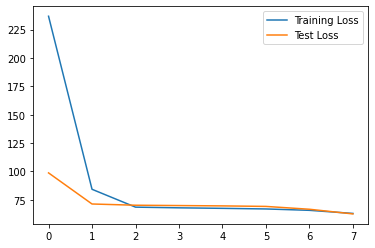

LOSS of the network on the test images: 1085 %
Mean of the network on the Indian images after epoch 7 is 60.314392725626625
LOSS of the network on the test images: 660 %
Mean of the network on the Western images after epoch 7 is 73.39898681640625


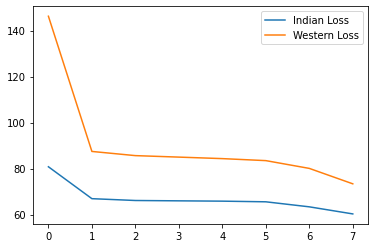

[9,     1] loss: 58.467
[9,     2] loss: 60.402
[9,     3] loss: 55.785
[9,     4] loss: 65.881
[9,     5] loss: 58.996
[9,     6] loss: 59.381
[9,     7] loss: 63.918
[9,     8] loss: 63.522
[9,     9] loss: 54.063
[9,    10] loss: 62.191
[9,    11] loss: 60.536
[9,    12] loss: 59.000
[9,    13] loss: 60.282
[9,    14] loss: 50.490
[9,    15] loss: 58.534
[9,    16] loss: 58.157
[9,    17] loss: 55.466
[9,    18] loss: 57.343
[9,    19] loss: 60.089
[9,    20] loss: 58.085
[9,    21] loss: 61.703
[9,    22] loss: 55.629
[9,    23] loss: 58.491
[9,    24] loss: 54.014
[9,    25] loss: 60.866
[9,    26] loss: 58.592
[9,    27] loss: 63.144
[9,    28] loss: 62.064
[9,    29] loss: 57.990
[9,    30] loss: 60.641
[9,    31] loss: 54.278
[9,    32] loss: 53.419
[9,    33] loss: 53.143
[9,    34] loss: 58.107
[9,    35] loss: 72.562
[9,    36] loss: 55.508
[9,    37] loss: 54.208
[9,    38] loss: 55.632
[9,    39] loss: 59.835
[9,    40] loss: 65.306
[9,    41] loss: 56.560
[9,    42] loss:

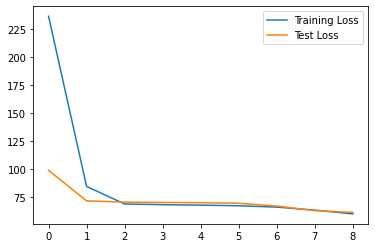

LOSS of the network on the test images: 1069 %
Mean of the network on the Indian images after epoch 8 is 59.4276974995931
LOSS of the network on the test images: 632 %
Mean of the network on the Western images after epoch 8 is 70.24989530775282


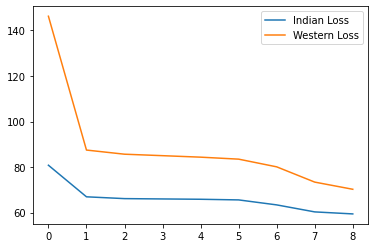

[10,     1] loss: 56.798
[10,     2] loss: 58.636
[10,     3] loss: 54.238
[10,     4] loss: 62.876
[10,     5] loss: 56.470
[10,     6] loss: 56.982
[10,     7] loss: 61.033
[10,     8] loss: 60.528
[10,     9] loss: 51.856
[10,    10] loss: 57.439
[10,    11] loss: 57.286
[10,    12] loss: 56.577
[10,    13] loss: 57.978
[10,    14] loss: 48.313
[10,    15] loss: 56.658
[10,    16] loss: 54.414
[10,    17] loss: 53.827
[10,    18] loss: 54.901
[10,    19] loss: 57.869
[10,    20] loss: 55.063
[10,    21] loss: 57.883
[10,    22] loss: 54.816
[10,    23] loss: 55.011
[10,    24] loss: 52.249
[10,    25] loss: 57.508
[10,    26] loss: 55.426
[10,    27] loss: 59.622
[10,    28] loss: 59.779
[10,    29] loss: 55.452
[10,    30] loss: 57.233
[10,    31] loss: 51.575
[10,    32] loss: 52.503
[10,    33] loss: 51.383
[10,    34] loss: 55.716
[10,    35] loss: 69.259
[10,    36] loss: 52.359
[10,    37] loss: 51.766
[10,    38] loss: 53.886
[10,    39] loss: 57.246
[10,    40] loss: 62.323


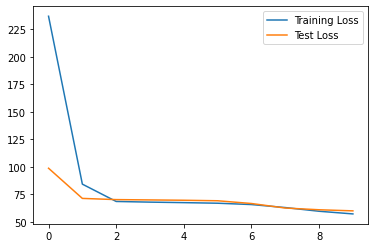

LOSS of the network on the test images: 1059 %
Mean of the network on the Indian images after epoch 9 is 58.85791036817763
LOSS of the network on the test images: 614 %
Mean of the network on the Western images after epoch 9 is 68.26007588704427


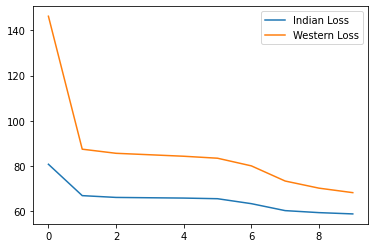

[11,     1] loss: 55.200
[11,     2] loss: 55.631
[11,     3] loss: 53.048
[11,     4] loss: 62.286
[11,     5] loss: 53.847
[11,     6] loss: 56.755
[11,     7] loss: 59.141
[11,     8] loss: 58.193
[11,     9] loss: 51.488
[11,    10] loss: 54.473
[11,    11] loss: 56.149
[11,    12] loss: 54.077
[11,    13] loss: 55.711
[11,    14] loss: 47.044
[11,    15] loss: 54.840
[11,    16] loss: 51.528
[11,    17] loss: 51.677
[11,    18] loss: 52.978
[11,    19] loss: 55.526
[11,    20] loss: 52.118
[11,    21] loss: 54.765
[11,    22] loss: 52.394
[11,    23] loss: 52.814
[11,    24] loss: 50.921
[11,    25] loss: 55.224
[11,    26] loss: 53.351
[11,    27] loss: 57.056
[11,    28] loss: 57.155
[11,    29] loss: 53.682
[11,    30] loss: 54.595
[11,    31] loss: 49.986
[11,    32] loss: 50.757
[11,    33] loss: 50.077
[11,    34] loss: 53.827
[11,    35] loss: 65.259
[11,    36] loss: 50.722
[11,    37] loss: 48.924
[11,    38] loss: 52.301
[11,    39] loss: 55.276
[11,    40] loss: 59.091


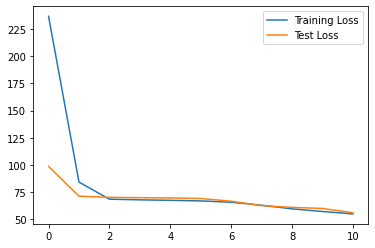

LOSS of the network on the test images: 990 %
Mean of the network on the Indian images after epoch 10 is 55.01613744099935
LOSS of the network on the test images: 573 %
Mean of the network on the Western images after epoch 10 is 63.68027920193143


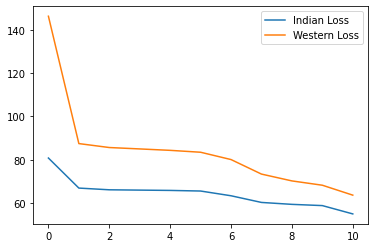

[12,     1] loss: 51.531
[12,     2] loss: 53.234
[12,     3] loss: 51.370
[12,     4] loss: 57.864
[12,     5] loss: 51.753
[12,     6] loss: 53.290
[12,     7] loss: 55.618
[12,     8] loss: 55.468
[12,     9] loss: 48.636
[12,    10] loss: 52.634
[12,    11] loss: 54.024
[12,    12] loss: 52.452
[12,    13] loss: 53.796
[12,    14] loss: 45.636
[12,    15] loss: 53.270
[12,    16] loss: 48.936
[12,    17] loss: 50.190
[12,    18] loss: 51.357
[12,    19] loss: 53.876
[12,    20] loss: 50.030
[12,    21] loss: 52.358
[12,    22] loss: 50.888
[12,    23] loss: 49.978
[12,    24] loss: 49.440
[12,    25] loss: 53.353
[12,    26] loss: 51.013
[12,    27] loss: 55.439
[12,    28] loss: 55.027
[12,    29] loss: 52.081
[12,    30] loss: 51.696
[12,    31] loss: 48.719
[12,    32] loss: 49.698
[12,    33] loss: 49.243
[12,    34] loss: 52.787
[12,    35] loss: 63.012
[12,    36] loss: 49.426
[12,    37] loss: 48.102
[12,    38] loss: 51.463
[12,    39] loss: 53.809
[12,    40] loss: 57.712


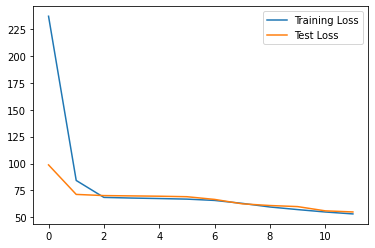

LOSS of the network on the test images: 978 %
Mean of the network on the Indian images after epoch 11 is 54.34671635097928
LOSS of the network on the test images: 555 %
Mean of the network on the Western images after epoch 11 is 61.77165222167969


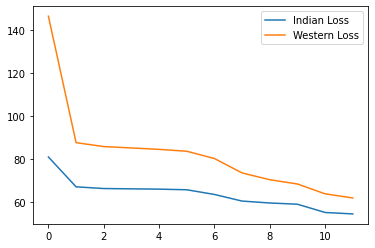

[13,     1] loss: 50.266
[13,     2] loss: 51.808
[13,     3] loss: 50.662
[13,     4] loss: 55.947
[13,     5] loss: 50.271
[13,     6] loss: 52.099
[13,     7] loss: 53.667
[13,     8] loss: 54.025
[13,     9] loss: 47.573
[13,    10] loss: 50.794
[13,    11] loss: 52.509
[13,    12] loss: 51.829
[13,    13] loss: 52.115
[13,    14] loss: 44.708
[13,    15] loss: 51.804
[13,    16] loss: 46.930
[13,    17] loss: 49.204
[13,    18] loss: 50.047
[13,    19] loss: 52.337
[13,    20] loss: 48.939
[13,    21] loss: 50.888
[13,    22] loss: 49.882
[13,    23] loss: 48.623
[13,    24] loss: 48.355
[13,    25] loss: 52.076
[13,    26] loss: 49.658
[13,    27] loss: 54.141
[13,    28] loss: 53.492
[13,    29] loss: 51.179
[13,    30] loss: 49.484
[13,    31] loss: 47.534
[13,    32] loss: 48.399
[13,    33] loss: 48.086
[13,    34] loss: 51.365
[13,    35] loss: 60.146
[13,    36] loss: 47.986
[13,    37] loss: 46.469
[13,    38] loss: 50.075
[13,    39] loss: 52.825
[13,    40] loss: 55.511


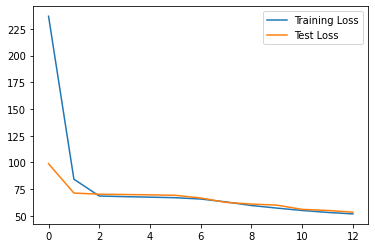

LOSS of the network on the test images: 954 %
Mean of the network on the Indian images after epoch 12 is 53.03977266947428
LOSS of the network on the test images: 534 %
Mean of the network on the Western images after epoch 12 is 59.340071784125435


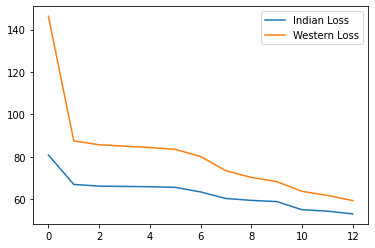

[14,     1] loss: 48.673
[14,     2] loss: 50.793
[14,     3] loss: 49.521
[14,     4] loss: 53.598
[14,     5] loss: 49.100
[14,     6] loss: 50.379
[14,     7] loss: 51.791
[14,     8] loss: 52.547
[14,     9] loss: 45.593
[14,    10] loss: 49.251
[14,    11] loss: 51.466
[14,    12] loss: 50.041
[14,    13] loss: 51.083
[14,    14] loss: 43.792
[14,    15] loss: 50.630
[14,    16] loss: 45.426
[14,    17] loss: 47.890
[14,    18] loss: 48.903
[14,    19] loss: 50.873
[14,    20] loss: 47.651
[14,    21] loss: 49.109
[14,    22] loss: 48.178
[14,    23] loss: 47.197
[14,    24] loss: 47.265
[14,    25] loss: 50.201
[14,    26] loss: 48.356
[14,    27] loss: 52.119
[14,    28] loss: 51.863
[14,    29] loss: 49.450
[14,    30] loss: 47.693
[14,    31] loss: 46.210
[14,    32] loss: 46.800
[14,    33] loss: 46.965
[14,    34] loss: 49.606
[14,    35] loss: 57.644
[14,    36] loss: 46.460
[14,    37] loss: 44.632
[14,    38] loss: 48.798
[14,    39] loss: 51.361
[14,    40] loss: 53.510


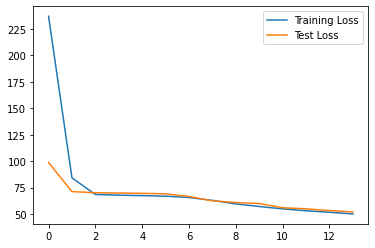

LOSS of the network on the test images: 936 %
Mean of the network on the Indian images after epoch 13 is 52.04170926411947
LOSS of the network on the test images: 515 %
Mean of the network on the Western images after epoch 13 is 57.26111136542426


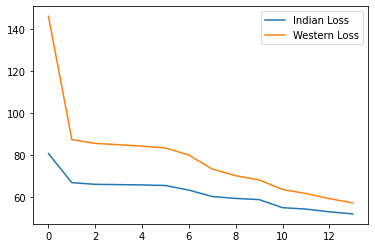

[15,     1] loss: 47.341
[15,     2] loss: 49.429
[15,     3] loss: 47.748
[15,     4] loss: 51.628
[15,     5] loss: 47.265
[15,     6] loss: 49.420
[15,     7] loss: 50.206
[15,     8] loss: 50.720
[15,     9] loss: 44.296
[15,    10] loss: 47.923
[15,    11] loss: 50.020
[15,    12] loss: 48.723
[15,    13] loss: 49.641
[15,    14] loss: 42.573
[15,    15] loss: 49.364
[15,    16] loss: 43.701
[15,    17] loss: 46.734
[15,    18] loss: 47.654
[15,    19] loss: 49.376
[15,    20] loss: 46.792
[15,    21] loss: 47.336
[15,    22] loss: 46.948
[15,    23] loss: 46.238
[15,    24] loss: 46.231
[15,    25] loss: 48.494
[15,    26] loss: 47.051
[15,    27] loss: 50.615
[15,    28] loss: 50.655
[15,    29] loss: 47.994
[15,    30] loss: 46.227
[15,    31] loss: 45.227
[15,    32] loss: 45.664
[15,    33] loss: 46.093
[15,    34] loss: 48.211
[15,    35] loss: 55.516
[15,    36] loss: 45.286
[15,    37] loss: 43.073
[15,    38] loss: 47.835
[15,    39] loss: 50.066
[15,    40] loss: 52.014


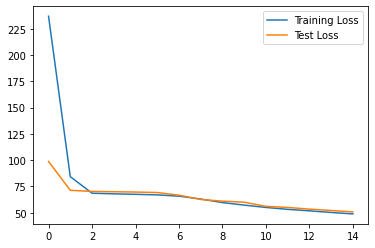

LOSS of the network on the test images: 915 %
Mean of the network on the Indian images after epoch 14 is 50.88352966308594
LOSS of the network on the test images: 498 %
Mean of the network on the Western images after epoch 14 is 55.439906650119354


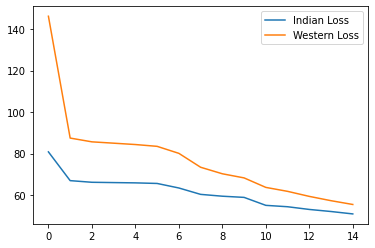

[16,     1] loss: 45.958
[16,     2] loss: 48.401
[16,     3] loss: 46.376
[16,     4] loss: 49.887
[16,     5] loss: 45.896
[16,     6] loss: 48.274
[16,     7] loss: 48.812
[16,     8] loss: 49.452
[16,     9] loss: 42.836
[16,    10] loss: 46.812
[16,    11] loss: 48.708
[16,    12] loss: 47.291
[16,    13] loss: 48.593
[16,    14] loss: 41.574
[16,    15] loss: 48.203
[16,    16] loss: 42.880
[16,    17] loss: 45.660
[16,    18] loss: 46.456
[16,    19] loss: 48.151
[16,    20] loss: 45.889
[16,    21] loss: 45.977
[16,    22] loss: 45.847
[16,    23] loss: 45.359
[16,    24] loss: 45.509
[16,    25] loss: 47.168
[16,    26] loss: 45.979
[16,    27] loss: 49.022
[16,    28] loss: 49.532
[16,    29] loss: 46.747
[16,    30] loss: 45.076
[16,    31] loss: 43.996
[16,    32] loss: 44.586
[16,    33] loss: 44.673
[16,    34] loss: 47.140
[16,    35] loss: 53.569
[16,    36] loss: 44.284
[16,    37] loss: 42.165
[16,    38] loss: 46.626
[16,    39] loss: 48.826
[16,    40] loss: 50.862


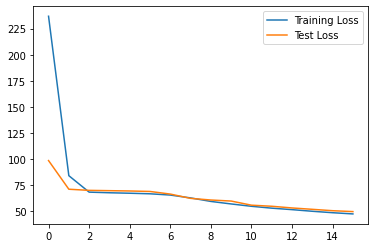

LOSS of the network on the test images: 904 %
Mean of the network on the Indian images after epoch 15 is 50.23380131191678
LOSS of the network on the test images: 486 %
Mean of the network on the Western images after epoch 15 is 54.09149720933702


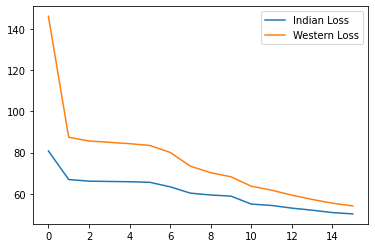

[17,     1] loss: 45.131
[17,     2] loss: 47.498
[17,     3] loss: 45.293
[17,     4] loss: 48.795
[17,     5] loss: 44.916
[17,     6] loss: 47.024
[17,     7] loss: 47.875
[17,     8] loss: 48.192
[17,     9] loss: 42.041
[17,    10] loss: 45.775
[17,    11] loss: 47.779
[17,    12] loss: 46.267
[17,    13] loss: 47.909
[17,    14] loss: 40.666
[17,    15] loss: 47.433
[17,    16] loss: 42.156
[17,    17] loss: 44.814
[17,    18] loss: 45.544
[17,    19] loss: 47.211
[17,    20] loss: 44.943
[17,    21] loss: 45.046
[17,    22] loss: 44.752
[17,    23] loss: 44.526
[17,    24] loss: 44.548
[17,    25] loss: 46.231
[17,    26] loss: 44.835
[17,    27] loss: 47.841
[17,    28] loss: 48.426
[17,    29] loss: 45.774
[17,    30] loss: 44.054
[17,    31] loss: 43.107
[17,    32] loss: 43.802
[17,    33] loss: 43.891
[17,    34] loss: 46.185
[17,    35] loss: 51.996
[17,    36] loss: 43.465
[17,    37] loss: 41.451
[17,    38] loss: 45.812
[17,    39] loss: 47.899
[17,    40] loss: 49.879


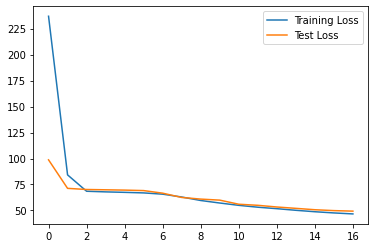

LOSS of the network on the test images: 897 %
Mean of the network on the Indian images after epoch 16 is 49.8603695763482
LOSS of the network on the test images: 479 %
Mean of the network on the Western images after epoch 16 is 53.26834699842665


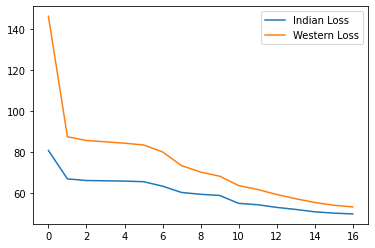

[18,     1] loss: 44.659
[18,     2] loss: 46.888
[18,     3] loss: 44.647
[18,     4] loss: 47.811
[18,     5] loss: 44.308
[18,     6] loss: 46.166
[18,     7] loss: 47.090
[18,     8] loss: 47.634
[18,     9] loss: 41.215
[18,    10] loss: 45.175
[18,    11] loss: 46.928
[18,    12] loss: 45.388
[18,    13] loss: 47.135
[18,    14] loss: 40.100
[18,    15] loss: 46.562
[18,    16] loss: 41.559
[18,    17] loss: 44.059
[18,    18] loss: 44.549
[18,    19] loss: 46.307
[18,    20] loss: 44.344
[18,    21] loss: 44.381
[18,    22] loss: 43.984
[18,    23] loss: 43.991
[18,    24] loss: 43.996
[18,    25] loss: 45.402
[18,    26] loss: 44.091
[18,    27] loss: 46.963
[18,    28] loss: 47.627
[18,    29] loss: 44.990
[18,    30] loss: 43.220
[18,    31] loss: 42.575
[18,    32] loss: 43.116
[18,    33] loss: 43.256
[18,    34] loss: 45.429
[18,    35] loss: 50.567
[18,    36] loss: 42.812
[18,    37] loss: 40.886
[18,    38] loss: 45.050
[18,    39] loss: 47.150
[18,    40] loss: 48.945


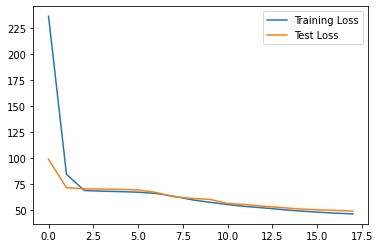

LOSS of the network on the test images: 885 %
Mean of the network on the Indian images after epoch 17 is 49.18990792168511
LOSS of the network on the test images: 470 %
Mean of the network on the Western images after epoch 17 is 52.306906382242836


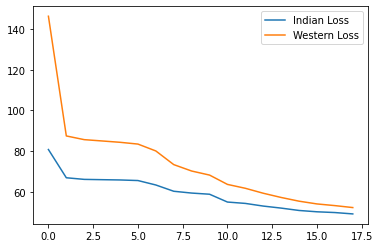

[19,     1] loss: 43.860
[19,     2] loss: 46.208
[19,     3] loss: 43.791
[19,     4] loss: 46.979
[19,     5] loss: 43.422
[19,     6] loss: 45.491
[19,     7] loss: 45.994
[19,     8] loss: 46.947
[19,     9] loss: 40.399
[19,    10] loss: 44.526
[19,    11] loss: 46.089
[19,    12] loss: 44.569
[19,    13] loss: 46.296
[19,    14] loss: 39.488
[19,    15] loss: 45.864
[19,    16] loss: 40.861
[19,    17] loss: 43.341
[19,    18] loss: 43.734
[19,    19] loss: 45.372
[19,    20] loss: 43.677
[19,    21] loss: 43.617
[19,    22] loss: 43.120
[19,    23] loss: 43.320
[19,    24] loss: 43.216
[19,    25] loss: 44.591
[19,    26] loss: 43.303
[19,    27] loss: 46.132
[19,    28] loss: 46.683
[19,    29] loss: 44.232
[19,    30] loss: 42.413
[19,    31] loss: 41.945
[19,    32] loss: 42.495
[19,    33] loss: 42.593
[19,    34] loss: 44.746
[19,    35] loss: 49.269
[19,    36] loss: 42.220
[19,    37] loss: 40.209
[19,    38] loss: 44.454
[19,    39] loss: 46.445
[19,    40] loss: 48.215


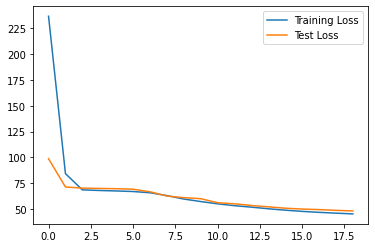

LOSS of the network on the test images: 876 %
Mean of the network on the Indian images after epoch 18 is 48.667761908637154
LOSS of the network on the test images: 464 %
Mean of the network on the Western images after epoch 18 is 51.57532034979926


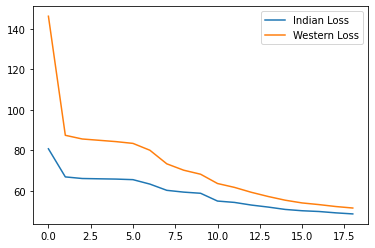

[20,     1] loss: 43.221
[20,     2] loss: 45.679
[20,     3] loss: 43.049
[20,     4] loss: 46.271
[20,     5] loss: 42.814
[20,     6] loss: 44.878
[20,     7] loss: 45.240
[20,     8] loss: 46.171
[20,     9] loss: 39.770
[20,    10] loss: 43.984
[20,    11] loss: 45.330
[20,    12] loss: 43.926
[20,    13] loss: 45.675
[20,    14] loss: 38.978
[20,    15] loss: 45.276
[20,    16] loss: 40.301
[20,    17] loss: 42.612
[20,    18] loss: 42.995
[20,    19] loss: 44.500
[20,    20] loss: 43.160
[20,    21] loss: 42.879
[20,    22] loss: 42.577
[20,    23] loss: 42.655
[20,    24] loss: 42.693
[20,    25] loss: 43.820
[20,    26] loss: 42.753
[20,    27] loss: 45.398
[20,    28] loss: 46.123
[20,    29] loss: 43.498
[20,    30] loss: 41.801
[20,    31] loss: 41.434
[20,    32] loss: 41.945
[20,    33] loss: 41.925
[20,    34] loss: 44.140
[20,    35] loss: 48.024
[20,    36] loss: 41.394
[20,    37] loss: 39.620
[20,    38] loss: 43.703
[20,    39] loss: 45.744
[20,    40] loss: 47.286


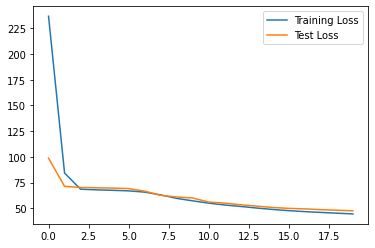

LOSS of the network on the test images: 866 %
Mean of the network on the Indian images after epoch 19 is 48.15774620903863
LOSS of the network on the test images: 457 %
Mean of the network on the Western images after epoch 19 is 50.87335756089952


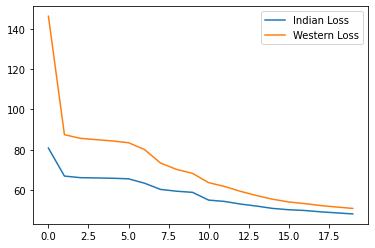

[21,     1] loss: 42.618
[21,     2] loss: 45.210
[21,     3] loss: 42.423
[21,     4] loss: 45.582
[21,     5] loss: 42.215
[21,     6] loss: 44.361
[21,     7] loss: 44.280
[21,     8] loss: 45.477
[21,     9] loss: 39.182
[21,    10] loss: 43.362
[21,    11] loss: 44.577
[21,    12] loss: 43.351
[21,    13] loss: 45.039
[21,    14] loss: 38.432
[21,    15] loss: 44.714
[21,    16] loss: 39.680
[21,    17] loss: 41.998
[21,    18] loss: 42.298
[21,    19] loss: 43.729
[21,    20] loss: 42.492
[21,    21] loss: 42.120
[21,    22] loss: 41.795
[21,    23] loss: 42.049
[21,    24] loss: 41.882
[21,    25] loss: 43.068
[21,    26] loss: 42.025
[21,    27] loss: 44.582
[21,    28] loss: 45.093
[21,    29] loss: 42.728
[21,    30] loss: 41.092
[21,    31] loss: 40.780
[21,    32] loss: 41.074
[21,    33] loss: 41.264
[21,    34] loss: 43.517
[21,    35] loss: 46.847
[21,    36] loss: 40.713
[21,    37] loss: 39.110
[21,    38] loss: 43.138
[21,    39] loss: 45.007
[21,    40] loss: 46.654


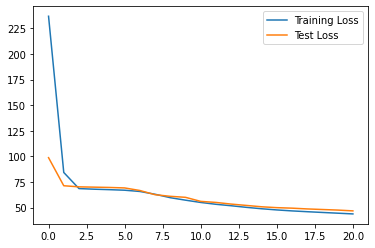

LOSS of the network on the test images: 853 %
Mean of the network on the Indian images after epoch 20 is 47.41570070054796
LOSS of the network on the test images: 449 %
Mean of the network on the Western images after epoch 20 is 49.931728786892364


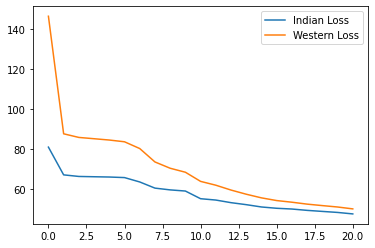

[22,     1] loss: 41.721
[22,     2] loss: 44.658
[22,     3] loss: 41.596
[22,     4] loss: 44.771
[22,     5] loss: 41.518
[22,     6] loss: 43.745
[22,     7] loss: 43.364
[22,     8] loss: 44.683
[22,     9] loss: 38.420
[22,    10] loss: 42.497
[22,    11] loss: 43.792
[22,    12] loss: 42.548
[22,    13] loss: 44.208
[22,    14] loss: 37.732
[22,    15] loss: 44.029
[22,    16] loss: 38.921
[22,    17] loss: 41.297
[22,    18] loss: 41.497
[22,    19] loss: 42.903
[22,    20] loss: 41.749
[22,    21] loss: 41.281
[22,    22] loss: 40.967
[22,    23] loss: 41.292
[22,    24] loss: 41.012
[22,    25] loss: 42.271
[22,    26] loss: 41.298
[22,    27] loss: 43.785
[22,    28] loss: 44.244
[22,    29] loss: 41.962
[22,    30] loss: 40.442
[22,    31] loss: 40.176
[22,    32] loss: 40.422
[22,    33] loss: 40.570
[22,    34] loss: 42.795
[22,    35] loss: 45.729
[22,    36] loss: 39.989
[22,    37] loss: 38.613
[22,    38] loss: 42.545
[22,    39] loss: 44.398
[22,    40] loss: 45.984


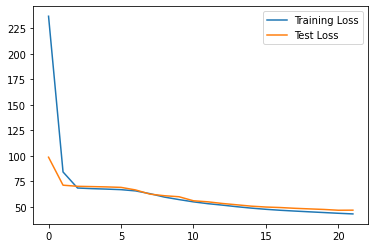

LOSS of the network on the test images: 853 %
Mean of the network on the Indian images after epoch 21 is 47.43199094136556
LOSS of the network on the test images: 451 %
Mean of the network on the Western images after epoch 21 is 50.154638078477646


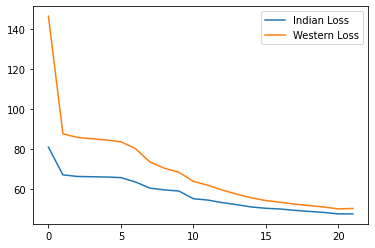

[23,     1] loss: 41.579
[23,     2] loss: 44.367
[23,     3] loss: 40.768
[23,     4] loss: 43.995
[23,     5] loss: 40.862
[23,     6] loss: 42.474
[23,     7] loss: 42.715
[23,     8] loss: 43.701
[23,     9] loss: 37.798
[23,    10] loss: 41.409
[23,    11] loss: 43.059
[23,    12] loss: 41.713
[23,    13] loss: 43.475
[23,    14] loss: 37.142
[23,    15] loss: 43.197
[23,    16] loss: 38.748
[23,    17] loss: 40.503
[23,    18] loss: 40.584
[23,    19] loss: 42.159
[23,    20] loss: 41.179
[23,    21] loss: 40.576
[23,    22] loss: 40.490
[23,    23] loss: 40.643
[23,    24] loss: 40.400
[23,    25] loss: 41.661
[23,    26] loss: 40.627
[23,    27] loss: 42.999
[23,    28] loss: 43.444
[23,    29] loss: 41.294
[23,    30] loss: 40.223
[23,    31] loss: 39.408
[23,    32] loss: 39.906
[23,    33] loss: 40.011
[23,    34] loss: 42.240
[23,    35] loss: 44.679
[23,    36] loss: 39.614
[23,    37] loss: 38.631
[23,    38] loss: 41.985
[23,    39] loss: 43.759
[23,    40] loss: 45.727


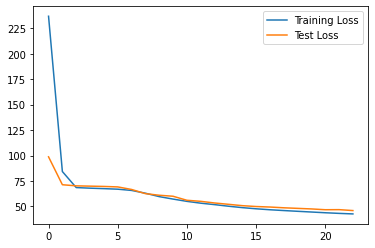

LOSS of the network on the test images: 838 %
Mean of the network on the Indian images after epoch 22 is 46.59483167860243
LOSS of the network on the test images: 441 %
Mean of the network on the Western images after epoch 22 is 49.01838853624132


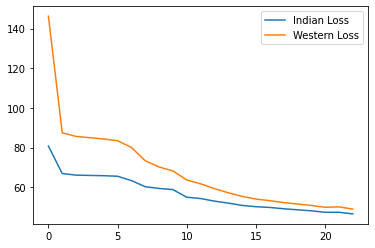

[24,     1] loss: 40.494
[24,     2] loss: 43.322
[24,     3] loss: 40.312
[24,     4] loss: 43.177
[24,     5] loss: 40.283
[24,     6] loss: 41.855
[24,     7] loss: 41.958
[24,     8] loss: 42.730
[24,     9] loss: 37.403
[24,    10] loss: 40.630
[24,    11] loss: 42.412
[24,    12] loss: 41.087
[24,    13] loss: 42.952
[24,    14] loss: 36.638
[24,    15] loss: 42.528
[24,    16] loss: 38.004
[24,    17] loss: 39.820
[24,    18] loss: 39.820
[24,    19] loss: 41.528
[24,    20] loss: 40.580
[24,    21] loss: 40.036
[24,    22] loss: 40.093
[24,    23] loss: 39.840
[24,    24] loss: 39.993
[24,    25] loss: 41.040
[24,    26] loss: 39.915
[24,    27] loss: 42.343
[24,    28] loss: 42.896
[24,    29] loss: 40.603
[24,    30] loss: 39.319
[24,    31] loss: 38.872
[24,    32] loss: 39.204
[24,    33] loss: 39.154
[24,    34] loss: 41.484
[24,    35] loss: 43.652
[24,    36] loss: 38.922
[24,    37] loss: 37.871
[24,    38] loss: 41.433
[24,    39] loss: 43.067
[24,    40] loss: 45.141


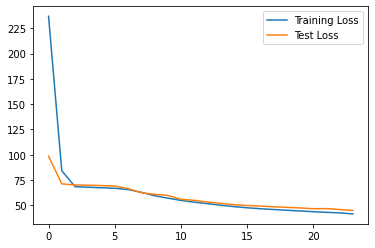

LOSS of the network on the test images: 821 %
Mean of the network on the Indian images after epoch 23 is 45.61115370856391
LOSS of the network on the test images: 433 %
Mean of the network on the Western images after epoch 23 is 48.12959416707357


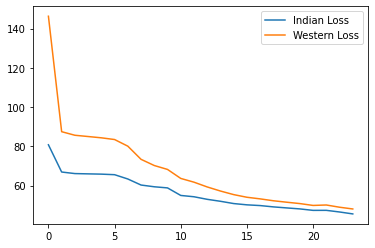

[25,     1] loss: 39.583
[25,     2] loss: 42.749
[25,     3] loss: 39.474
[25,     4] loss: 42.230
[25,     5] loss: 39.489
[25,     6] loss: 40.922
[25,     7] loss: 40.868
[25,     8] loss: 41.901
[25,     9] loss: 36.535
[25,    10] loss: 39.762
[25,    11] loss: 41.326
[25,    12] loss: 40.322
[25,    13] loss: 41.799
[25,    14] loss: 35.897
[25,    15] loss: 41.592
[25,    16] loss: 37.058
[25,    17] loss: 38.990
[25,    18] loss: 38.773
[25,    19] loss: 40.504
[25,    20] loss: 39.762
[25,    21] loss: 38.879
[25,    22] loss: 38.841
[25,    23] loss: 38.959
[25,    24] loss: 38.911
[25,    25] loss: 39.840
[25,    26] loss: 39.032
[25,    27] loss: 41.200
[25,    28] loss: 41.780
[25,    29] loss: 39.677
[25,    30] loss: 38.416
[25,    31] loss: 38.009
[25,    32] loss: 38.465
[25,    33] loss: 38.348
[25,    34] loss: 40.412
[25,    35] loss: 42.427
[25,    36] loss: 38.002
[25,    37] loss: 37.074
[25,    38] loss: 40.766
[25,    39] loss: 42.097
[25,    40] loss: 43.980


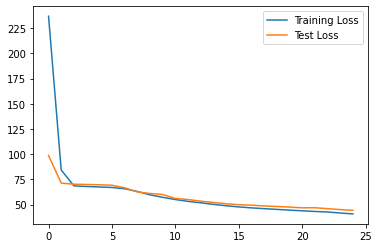

LOSS of the network on the test images: 809 %
Mean of the network on the Indian images after epoch 24 is 44.95521608988444
LOSS of the network on the test images: 424 %
Mean of the network on the Western images after epoch 24 is 47.2140621609158


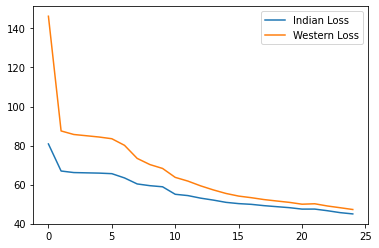

[26,     1] loss: 38.592
[26,     2] loss: 41.886
[26,     3] loss: 38.623
[26,     4] loss: 41.282
[26,     5] loss: 38.607
[26,     6] loss: 40.242
[26,     7] loss: 39.981
[26,     8] loss: 40.927
[26,     9] loss: 35.793
[26,    10] loss: 38.884
[26,    11] loss: 40.495
[26,    12] loss: 39.454
[26,    13] loss: 40.952
[26,    14] loss: 35.213
[26,    15] loss: 40.723
[26,    16] loss: 36.464
[26,    17] loss: 38.391
[26,    18] loss: 37.910
[26,    19] loss: 39.625
[26,    20] loss: 39.075
[26,    21] loss: 38.002
[26,    22] loss: 38.046
[26,    23] loss: 38.256
[26,    24] loss: 37.978
[26,    25] loss: 38.840
[26,    26] loss: 38.251
[26,    27] loss: 40.290
[26,    28] loss: 40.883
[26,    29] loss: 38.781
[26,    30] loss: 37.711
[26,    31] loss: 37.333
[26,    32] loss: 37.645
[26,    33] loss: 37.487
[26,    34] loss: 39.525
[26,    35] loss: 41.390
[26,    36] loss: 37.302
[26,    37] loss: 36.415
[26,    38] loss: 40.180
[26,    39] loss: 41.344
[26,    40] loss: 42.856


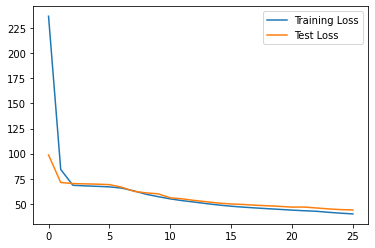

LOSS of the network on the test images: 803 %
Mean of the network on the Indian images after epoch 25 is 44.6598392062717
LOSS of the network on the test images: 420 %
Mean of the network on the Western images after epoch 25 is 46.71964009602865


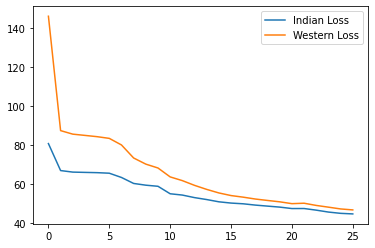

[27,     1] loss: 38.137
[27,     2] loss: 40.922
[27,     3] loss: 37.843
[27,     4] loss: 40.290
[27,     5] loss: 38.307
[27,     6] loss: 39.477
[27,     7] loss: 39.572
[27,     8] loss: 39.928
[27,     9] loss: 35.668
[27,    10] loss: 38.086
[27,    11] loss: 40.070
[27,    12] loss: 38.718
[27,    13] loss: 40.637
[27,    14] loss: 34.689
[27,    15] loss: 40.076
[27,    16] loss: 35.711
[27,    17] loss: 37.660
[27,    18] loss: 37.078
[27,    19] loss: 39.202
[27,    20] loss: 38.745
[27,    21] loss: 37.275
[27,    22] loss: 37.663
[27,    23] loss: 37.554
[27,    24] loss: 37.434
[27,    25] loss: 37.898
[27,    26] loss: 37.621
[27,    27] loss: 39.777
[27,    28] loss: 40.118
[27,    29] loss: 38.163
[27,    30] loss: 36.766
[27,    31] loss: 36.848
[27,    32] loss: 36.822
[27,    33] loss: 36.749
[27,    34] loss: 38.525
[27,    35] loss: 40.243
[27,    36] loss: 36.725
[27,    37] loss: 35.525
[27,    38] loss: 39.011
[27,    39] loss: 40.682
[27,    40] loss: 41.929


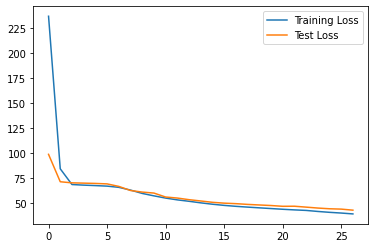

LOSS of the network on the test images: 785 %
Mean of the network on the Indian images after epoch 26 is 43.663173039754234
LOSS of the network on the test images: 408 %
Mean of the network on the Western images after epoch 26 is 45.433831532796226


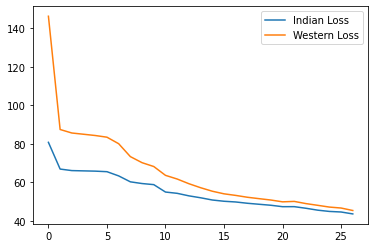

[28,     1] loss: 36.875
[28,     2] loss: 39.895
[28,     3] loss: 36.848
[28,     4] loss: 39.348
[28,     5] loss: 37.248
[28,     6] loss: 38.460
[28,     7] loss: 38.647
[28,     8] loss: 39.030
[28,     9] loss: 34.530
[28,    10] loss: 37.161
[28,    11] loss: 38.978
[28,    12] loss: 37.700
[28,    13] loss: 39.458
[28,    14] loss: 33.689
[28,    15] loss: 38.841
[28,    16] loss: 34.696
[28,    17] loss: 36.628
[28,    18] loss: 35.925
[28,    19] loss: 38.015
[28,    20] loss: 37.748
[28,    21] loss: 36.250
[28,    22] loss: 36.471
[28,    23] loss: 36.510
[28,    24] loss: 36.486
[28,    25] loss: 36.818
[28,    26] loss: 36.531
[28,    27] loss: 38.604
[28,    28] loss: 39.001
[28,    29] loss: 37.098
[28,    30] loss: 35.868
[28,    31] loss: 35.869
[28,    32] loss: 35.885
[28,    33] loss: 35.805
[28,    34] loss: 37.495
[28,    35] loss: 38.857
[28,    36] loss: 35.631
[28,    37] loss: 34.418
[28,    38] loss: 37.905
[28,    39] loss: 39.574
[28,    40] loss: 40.773


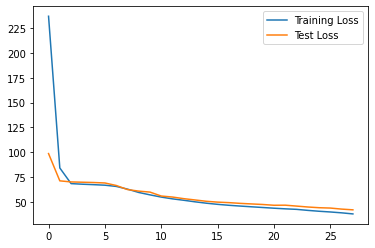

LOSS of the network on the test images: 773 %
Mean of the network on the Indian images after epoch 27 is 42.945060306125214
LOSS of the network on the test images: 401 %
Mean of the network on the Western images after epoch 27 is 44.61998070610894


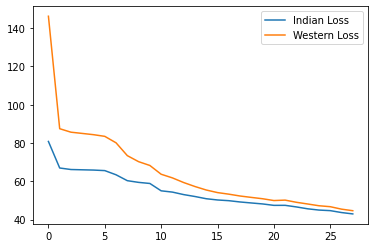

[29,     1] loss: 36.007
[29,     2] loss: 38.912
[29,     3] loss: 35.833
[29,     4] loss: 38.173
[29,     5] loss: 36.452
[29,     6] loss: 37.362
[29,     7] loss: 37.719
[29,     8] loss: 37.803
[29,     9] loss: 33.714
[29,    10] loss: 36.092
[29,    11] loss: 37.942
[29,    12] loss: 36.735
[29,    13] loss: 38.434
[29,    14] loss: 32.754
[29,    15] loss: 37.658
[29,    16] loss: 33.862
[29,    17] loss: 35.576
[29,    18] loss: 34.876
[29,    19] loss: 36.870
[29,    20] loss: 36.999
[29,    21] loss: 35.215
[29,    22] loss: 35.546
[29,    23] loss: 35.417
[29,    24] loss: 35.603
[29,    25] loss: 35.847
[29,    26] loss: 35.603
[29,    27] loss: 37.462
[29,    28] loss: 38.004
[29,    29] loss: 36.006
[29,    30] loss: 34.936
[29,    31] loss: 34.924
[29,    32] loss: 35.009
[29,    33] loss: 34.824
[29,    34] loss: 36.449
[29,    35] loss: 37.525
[29,    36] loss: 34.664
[29,    37] loss: 33.154
[29,    38] loss: 36.697
[29,    39] loss: 38.391
[29,    40] loss: 39.614


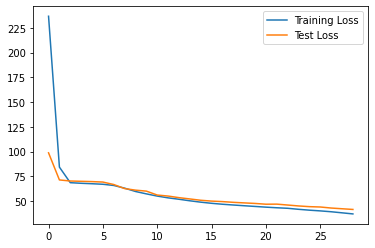

LOSS of the network on the test images: 759 %
Mean of the network on the Indian images after epoch 28 is 42.1786020067003
LOSS of the network on the test images: 396 %
Mean of the network on the Western images after epoch 28 is 44.01230239868164


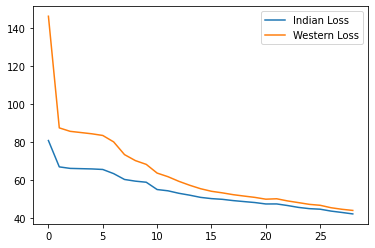

[30,     1] loss: 35.095
[30,     2] loss: 38.395
[30,     3] loss: 35.164
[30,     4] loss: 37.093
[30,     5] loss: 35.407
[30,     6] loss: 36.289
[30,     7] loss: 36.394
[30,     8] loss: 37.023
[30,     9] loss: 33.123
[30,    10] loss: 35.063
[30,    11] loss: 36.722
[30,    12] loss: 35.883
[30,    13] loss: 37.416
[30,    14] loss: 31.771
[30,    15] loss: 36.377
[30,    16] loss: 33.140
[30,    17] loss: 34.666
[30,    18] loss: 33.893
[30,    19] loss: 35.625
[30,    20] loss: 35.568
[30,    21] loss: 34.257
[30,    22] loss: 34.339
[30,    23] loss: 34.335
[30,    24] loss: 34.328
[30,    25] loss: 34.587
[30,    26] loss: 34.512
[30,    27] loss: 36.223
[30,    28] loss: 36.932
[30,    29] loss: 35.459
[30,    30] loss: 34.264
[30,    31] loss: 34.006
[30,    32] loss: 34.241
[30,    33] loss: 34.345
[30,    34] loss: 35.441
[30,    35] loss: 36.080
[30,    36] loss: 33.745
[30,    37] loss: 32.188
[30,    38] loss: 35.708
[30,    39] loss: 37.359
[30,    40] loss: 38.335


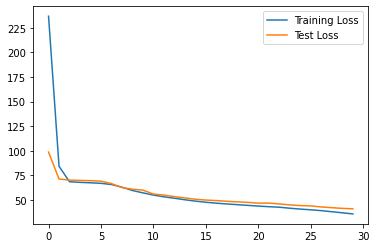

LOSS of the network on the test images: 748 %
Mean of the network on the Indian images after epoch 29 is 41.603873358832466
LOSS of the network on the test images: 393 %
Mean of the network on the Western images after epoch 29 is 43.67086325751411


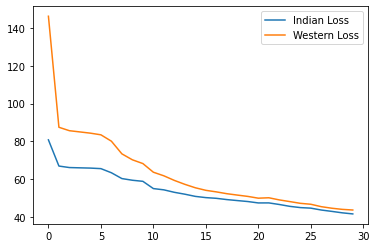

Finished Training


In [30]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)


    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(indian_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Indian images after epoch {} is {}'.format(epoch, total_Loss) )

    indian_loss_graph.append(total_Loss)

    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(western_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Western images after epoch {} is {}'.format(epoch, total_Loss) )

    western_loss_graph.append(total_Loss)

    visualize_class_loss(indian_loss_graph, western_loss_graph)
          

print('Finished Training')

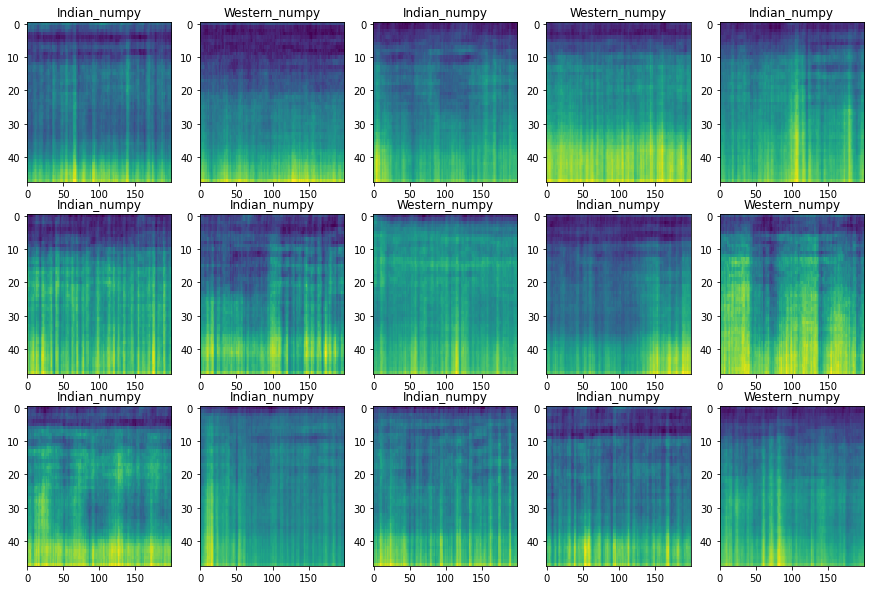

In [31]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

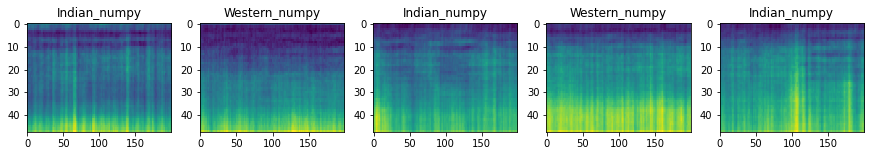

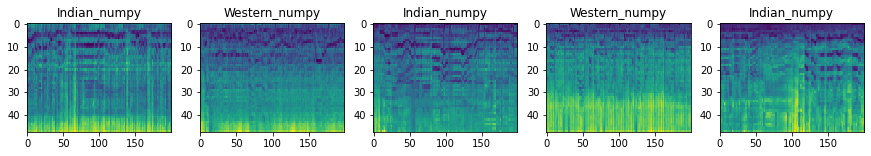

In [32]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [33]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [34]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [35]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [36]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [37]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_numpy/indianValliKanavan_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Western_numpy/western_137212_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_numpy/indianEmaiPoyave_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Western_numpy/western_014740_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_numpy/indianThoratheDuet_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_numpy/indianKannaveKannave_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_numpy/indianIshqbazian_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Western_numpy/western_123441_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_numpy/indianEeKanninalli_mel_1.npy
/co

In [38]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1

/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianBaateinKuchAnkaheeSi_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianThumka_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianEnnaSolla_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianSaraswathi_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianMainAgarKahoon_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianTammaTammaAgain_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianKaadalEndral_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/indianYehDilToMilaHai_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/tr